# Naive Feature Visualization

In [250]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

device = 'cpu'

# common function to show results of different visualizations
def show_result(_imgs, _thresholds):
    fig, axs = plt.subplots(1, len(_imgs), figsize=(20, 4))
    for i, img in enumerate(_imgs):
        # Resize image to double its size
        img_resized = resize(torch.from_numpy(img), [image_size*2, image_size*2])
        # in InceptionV1 the dimensions of the resulting image are (channels, height, width)
        # matplotlib expects (height, width, channels)
        img_resized = img_resized.permute(1, 2, 0).numpy()
        
        # display the image on a specific axis
        axs[i].imshow(img_resized)
        # disable x/y number grid
        axs[i].axis('off')
        axs[i].set_title(f'Iteration {_thresholds[i]}')
    
    plt.tight_layout() # makes arrangement of the images a bit nicer
    plt.show()

In [251]:
import torch.nn as nn

def pixel_image(shape, sd=0.01):
    return np.random.normal(size=shape, scale=sd).astype(np.float32)

class ParameterizedImage(nn.Module):
    def __init__(self, w, h=None, batch=1, sd=0.01, channels=3):
        super().__init__()
        h = h or w
        shape = [batch, channels, h, w]
        init_val = pixel_image(shape, sd=sd)
        self.param = nn.Parameter(torch.tensor(init_val))

    def forward(self):
        return torch.sigmoid(self.param)

In [252]:
import torchvision.models as models

# Load pre-trained Inception v1 (GoogLeNet in PyTorch)
model = models.googlenet(pretrained=True).eval()
model.to(device)

# Set up the layer we want to visualize
# In this case, we'll use the equivalent of "mixed4b_pre_relu:452" in InceptionV1
# This corresponds to the 4th Inception module, b branch, before ReLU
target_layer = model.inception4b
target_channel = 450

# Parameters
image_size = 64
learning_rate = 0.01
num_iterations = 2048
thresholds = [1, 32, 128, 256, 2048]

# Hook to get intermediate layer output
# activation dict in this implementation will always have a single kv pair (target: activation)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

# register a hook to be able to fetch activations of this particular layer/channel later
target_layer.register_forward_hook(get_activation('target'))

In [259]:
# function where we perform forward pass, extract average activation (as a single number) and return negation of it
# negation because we have to _maximize_ the objective and _minimize_ the loss
# so if loss will go from 15 to 7 (lowering), objective will go from -15 to -7 (growing)
def visualize_naive(_image, _transform):
    model(parameterized_image())
    loss = -activation['target'][:, target_channel].mean()
    loss.backward()
    return loss.item()

# Render function
def render_vis(_image, _optimizer, _thresholds, _visualize, _transform=None, *_visualize_params):
    images = []
    for i in range(num_iterations + 1):
        _optimizer.zero_grad()
        loss = _visualize(_image, _transform, *_visualize_params)
        _optimizer.step()
        
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss}")
        
        # Clamp values to [0, 1]
        with torch.no_grad():
            _image().clamp_(0, 1)
        
        if i in _thresholds:
            img_np = (_image()
                      .squeeze() # remove batch dimension
                      .detach() # detach from graph (will not be included in autograd and never require the gradient) 
                      .cpu() # from mps/cuda -> cpu
                      .numpy() # to numpy array instead of pytorch.Tensor
                      )
            images.append(np.copy(img_np))
    
    return images

In [260]:
# Create a parameter to optimize
# 1 -- batch size
# 3 -- channels (colour)
# image_size -- actual width (and height)
# require_grad -- change values generated by randn
parameterized_image = ParameterizedImage(image_size, sd=0.01).to(device)
optimizer = torch.optim.Adam(parameterized_image.parameters(), lr=learning_rate)

# obtain ready-to-display feature visualizations
imgs = render_vis(parameterized_image, optimizer, thresholds, visualize_naive)

Iteration 0, Loss: -1.115426778793335
Iteration 100, Loss: -10.26222038269043
Iteration 200, Loss: -11.867277145385742
Iteration 300, Loss: -12.840758323669434
Iteration 400, Loss: -13.44915771484375
Iteration 500, Loss: -13.896974563598633
Iteration 600, Loss: -14.26315689086914
Iteration 700, Loss: -14.607415199279785
Iteration 800, Loss: -14.877179145812988
Iteration 900, Loss: -15.130589485168457
Iteration 1000, Loss: -15.353212356567383
Iteration 1100, Loss: -15.53912353515625
Iteration 1200, Loss: -15.687946319580078
Iteration 1300, Loss: -15.827043533325195
Iteration 1400, Loss: -15.95017147064209
Iteration 1500, Loss: -16.059972763061523
Iteration 1600, Loss: -16.153045654296875
Iteration 1700, Loss: -16.24020004272461
Iteration 1800, Loss: -16.317968368530273
Iteration 1900, Loss: -16.39097785949707
Iteration 2000, Loss: -16.45802116394043


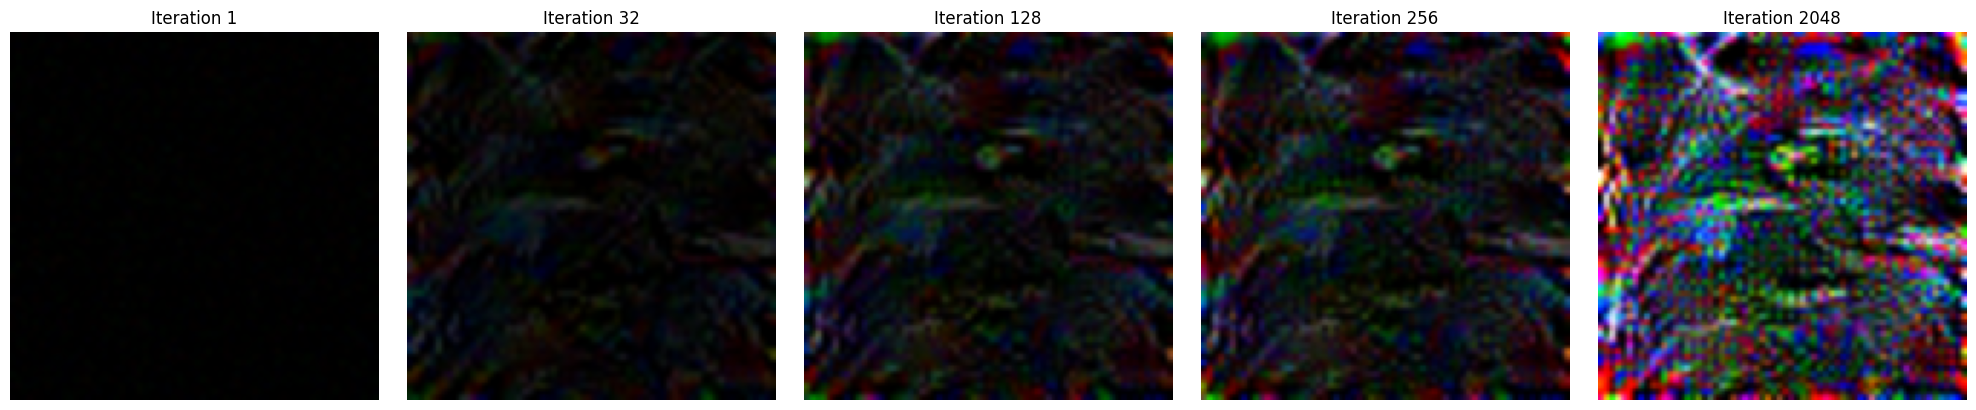

In [148]:
# create len(imgs) subplots (5 in this case)
show_result(imgs, thresholds) # WITHOUT SIGMOID

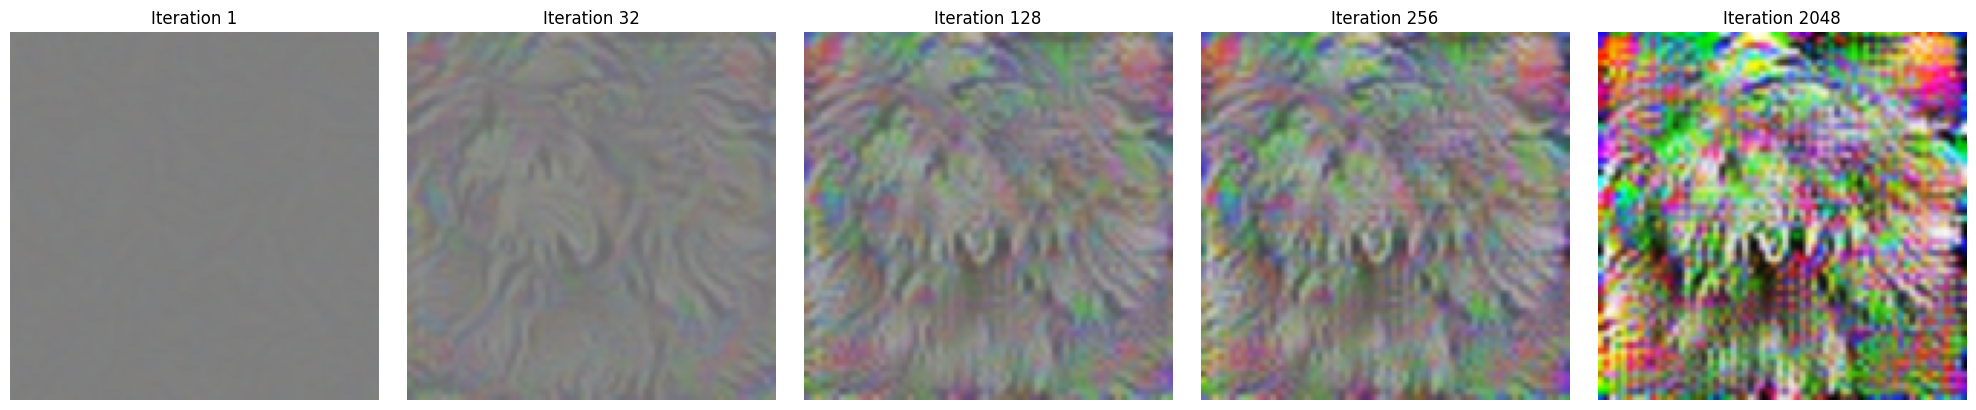

In [261]:
show_result(imgs, thresholds)

### Target Layer
target_layer is one of the layers of Inception model

btw, in branch3 they have 3x3 convolution instead of 5x5 -- it's a <a href="https://github.com/pytorch/vision/issues/906">known bug</a> (:

In [262]:
target_layer

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(512, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(112, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(224, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): B

# Feature Visualization with L1 + Total Variation + Blur

In [263]:
import torch.nn.functional as F

def total_variation(img):
     bs_img, c_img, h_img, w_img = img.size()
     tv_h = torch.sum(torch.abs(img[:,:,1:,:]-img[:,:,:-1,:]))
     tv_w = torch.sum(torch.abs(img[:,:,:,1:]-img[:,:,:,:-1]))
     return (tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

def l1_reg(img, constant=0.5):
    return torch.mean(torch.abs(img - constant))

def blur_reg(x, kernel_size=3):
    # Create a Gaussian kernel
    kernel = torch.ones((1, 1, kernel_size, kernel_size)) / (kernel_size ** 2)
    kernel = kernel.to(x.device)
    
    blurred = torch.zeros_like(x)
    for c in range(x.shape[1]):  # iterate over channels
        blurred[:, c:c+1] = F.conv2d(x[:, c:c+1], kernel, padding=kernel_size//2)
    
    # Compute the difference between the original and blurred image
    return torch.mean((x - blurred) ** 2)

def visualize_tv(_image, _transform, tv_strength=0.25, l1_strength=0.05, blur_strength=1.0):
    image_torch = _image()
    model(image_torch)
    activation_loss = -activation['target'][:, target_channel].mean()
    tv_loss = total_variation(image_torch)
    l1_loss = l1_reg(image_torch)
    blur_loss = blur_reg(image_torch)
    
    loss = activation_loss + tv_strength * tv_loss + l1_strength * l1_loss + blur_strength * blur_loss
    loss.backward()
    return loss.item()

In [264]:
parameterized_image_tv = ParameterizedImage(image_size, sd=0.01).to(device)
optimizer_tv = torch.optim.Adam(parameterized_image_tv.parameters(), lr=learning_rate)

# obtain ready-to-display feature visualizations
imgs_tv = render_vis(parameterized_image_tv, optimizer_tv, thresholds, visualize_tv)

Iteration 0, Loss: -1.115594506263733
Iteration 100, Loss: -10.00230884552002
Iteration 200, Loss: -12.195673942565918
Iteration 300, Loss: -13.3280029296875
Iteration 400, Loss: -13.931780815124512
Iteration 500, Loss: -14.33036994934082
Iteration 600, Loss: -14.647088050842285
Iteration 700, Loss: -14.906096458435059
Iteration 800, Loss: -15.109785079956055
Iteration 900, Loss: -15.2904634475708
Iteration 1000, Loss: -15.45561695098877
Iteration 1100, Loss: -15.596161842346191
Iteration 1200, Loss: -15.706143379211426
Iteration 1300, Loss: -15.801562309265137
Iteration 1400, Loss: -15.896269798278809
Iteration 1500, Loss: -15.983614921569824
Iteration 1600, Loss: -16.069013595581055
Iteration 1700, Loss: -16.14284324645996
Iteration 1800, Loss: -16.20682144165039
Iteration 1900, Loss: -16.273550033569336
Iteration 2000, Loss: -16.337255477905273


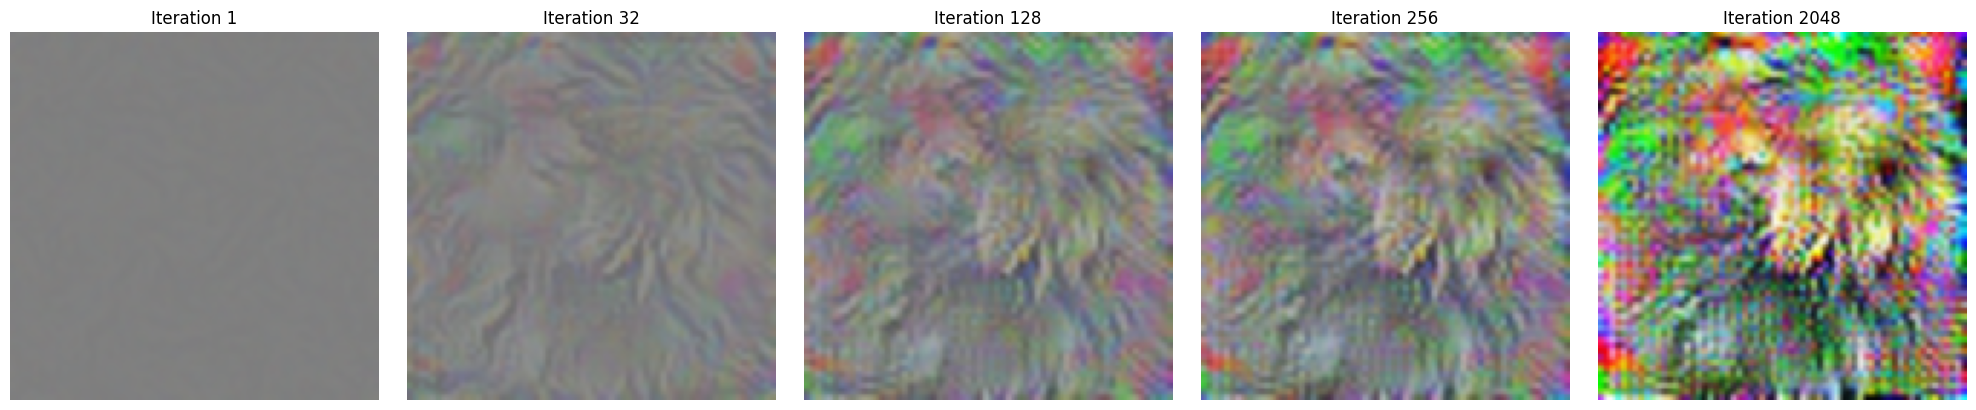

In [265]:
show_result(imgs_tv, thresholds)

# Transformation Robustness

In [266]:
def visualize_tr(_image, _transform, tv_strength=0.25, l1_strength=0.05, blur_strength=1.0):
    if isinstance(_image, torch.Tensor):
        image_torch = _image
    else:
        image_torch = _image()
    
    # Apply transformations
    transformed_image = _transform(image_torch)
    
    # Forward pass
    model(transformed_image)
    
    activation_loss = -activation['target'][0, target_channel].mean()
    tv_loss = total_variation(image_torch)
    l1_loss = l1_reg(image_torch)
    blur_loss = blur_reg(image_torch)
    
    loss = activation_loss + tv_strength * tv_loss + l1_strength * l1_loss + blur_strength * blur_loss
    loss.backward()
    return loss.item()

In [269]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class TransformationRobustness(nn.Module):
    def __init__(self, padding=16, jitter1=16, jitter2=8, 
                 scales=[1, 0.975, 1.025, 0.95, 1.05],
                 rotations=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]):
        super().__init__()
        self.padding = padding
        self.jitter1 = jitter1
        self.jitter2 = jitter2
        self.scales = scales
        self.rotations = rotations

    def forward(self, x):
        # Original size
        _, _, h, w = x.size()
        
        # 1. Padding
        x = F.pad(x, (self.padding,)*4, mode='constant')
        
        # 2. First jittering
        jitter1_x = random.randint(0, self.jitter1)
        jitter1_y = random.randint(0, self.jitter1)
        x = x[:, :, jitter1_y:jitter1_y+h+2*self.padding, jitter1_x:jitter1_x+w+2*self.padding]
        
        # 3. Scaling
        scale = random.choice(self.scales)
        if scale != 1:
            new_h, new_w = int(h * scale), int(w * scale)
            x = F.interpolate(x, size=(new_h + 2*self.padding, new_w + 2*self.padding), mode='bilinear', align_corners=False)
        
        # 4. Rotation
        angle = random.choice(self.rotations)
        if angle != 0:
            x = self.rotate_image(x, angle)
        
        # 5. Second jittering
        jitter2_x = random.randint(0, self.jitter2)
        jitter2_y = random.randint(0, self.jitter2)
        x = x[:, :, jitter2_y:jitter2_y+h+2*self.padding, jitter2_x:jitter2_x+w+2*self.padding]
        
        # 6. Cropping the padding
        x = x[:, :, self.padding:self.padding+h, self.padding:self.padding+w]
        
        return x

    def rotate_image(self, x, angle):
        # Convert angle to radians
        angle = torch.tensor(angle * torch.pi / 180)
        
        # Create rotation matrix
        rot_mat = torch.tensor([
            [torch.cos(angle), -torch.sin(angle), 0],
            [torch.sin(angle), torch.cos(angle), 0]
        ], device=x.device).unsqueeze(0)
        
        # Create grid
        grid = F.affine_grid(rot_mat, x.size(), align_corners=False)
        
        # Apply rotation
        x = F.grid_sample(x, grid, align_corners=False, mode='bilinear')
        
        return x

In [270]:
transform = TransformationRobustness().to(device)
parameterized_image_tr = ParameterizedImage(image_size, sd=0.1).to(device)
optimizer_tr = torch.optim.Adam(parameterized_image_tr.parameters(), lr=learning_rate)

# obtain ready-to-display feature visualizations
imgs_tr = render_vis(parameterized_image_tr, optimizer_tr, thresholds, visualize_tr, transform)

Iteration 0, Loss: -0.23404644429683685
Iteration 100, Loss: -3.821321964263916
Iteration 200, Loss: -5.71409797668457
Iteration 300, Loss: -6.399771690368652
Iteration 400, Loss: -7.003022193908691
Iteration 500, Loss: -7.294460773468018
Iteration 600, Loss: -8.069975852966309
Iteration 700, Loss: -7.5452880859375
Iteration 800, Loss: -8.135799407958984
Iteration 900, Loss: -8.609870910644531
Iteration 1000, Loss: -8.284002304077148
Iteration 1100, Loss: -7.797151565551758
Iteration 1200, Loss: -9.079784393310547
Iteration 1300, Loss: -9.349198341369629
Iteration 1400, Loss: -8.602187156677246
Iteration 1500, Loss: -9.457971572875977
Iteration 1600, Loss: -9.595230102539062
Iteration 1700, Loss: -8.6947660446167
Iteration 1800, Loss: -9.298154830932617
Iteration 1900, Loss: -9.716134071350098
Iteration 2000, Loss: -9.285700798034668


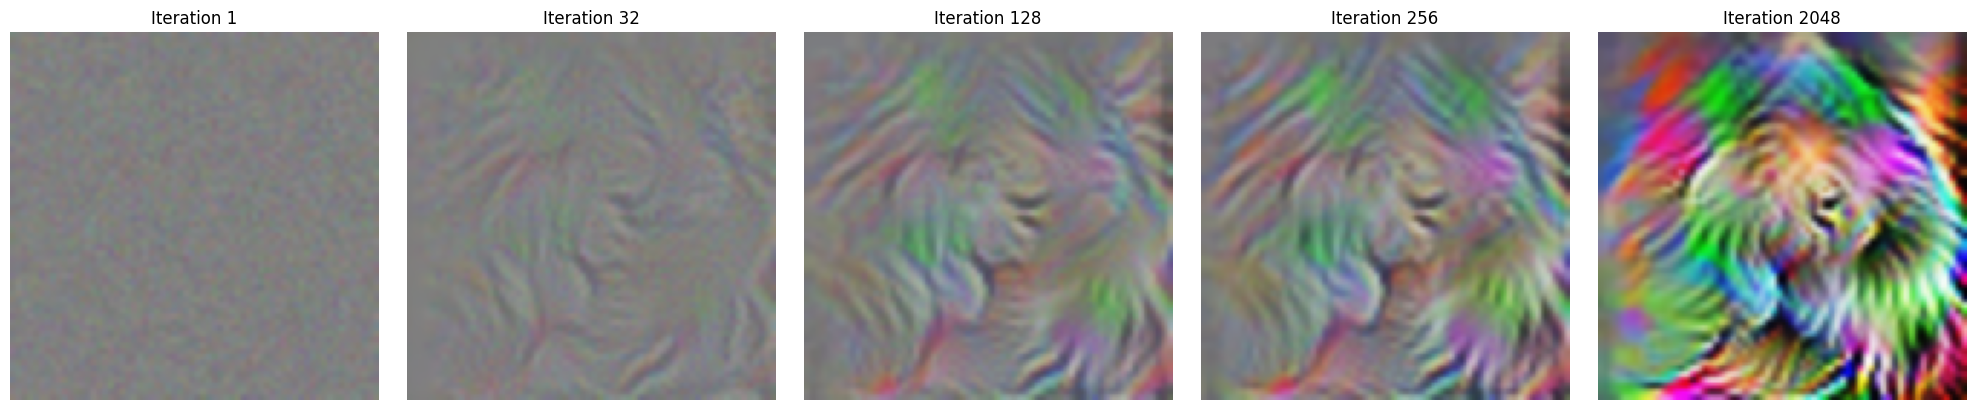

In [271]:
show_result(imgs_tr, thresholds)

# Decorrelated Space (Preconditioning) + TR

In [272]:
import numpy as np

def get_fft_scale(shape, decay_power=1):
    freqs = np.fft.fftfreq(shape[-1])[:, None] ** 2 + np.fft.fftfreq(shape[-2])[None, :] ** 2
    return (1 + freqs) ** (-decay_power / 2)

def to_decorrelated_space(image, decay_power=1):
    scale = get_fft_scale(image.shape[-2:], decay_power)
    scale = torch.from_numpy(scale).float().to(image.device)
    
    fft_img = torch.fft.rfft2(image)
    return torch.fft.irfft2(fft_img * scale[None, None, :, :fft_img.shape[-1]])

def from_decorrelated_space(image, decay_power=1):
    scale = get_fft_scale(image.shape[-2:], decay_power)
    scale = torch.from_numpy(scale).float().to(image.device)
    
    fft_img = torch.fft.rfft2(image)
    return torch.fft.irfft2(fft_img / scale[None, None, :, :fft_img.shape[-1]])

In [273]:
def render_vis_ds_tr(_image, _optimizer, _thresholds, _visualize, *_visualize_params):
    images = []
    for i in range(num_iterations + 1):
        _optimizer.zero_grad()
        decor_image = from_decorrelated_space(_image(), 1)
        loss = _visualize(decor_image, *_visualize_params)
        _optimizer.step()
        
        # Clamp values to [0, 1]
        with torch.no_grad():
            _image().clamp_(0, 1)
            _image().data.copy_(to_decorrelated_space(decor_image, 1))
        
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss}")
        
        if i in _thresholds:
            img_np = (_image()
                      .squeeze() # remove batch dimension
                      .detach() # detach from graph (will not be included in autograd and never require the gradient) 
                      .cpu() # from mps/cuda -> cpu
                      .numpy() # to numpy array instead of pytorch.Tensor
                      )
            images.append(img_np)
    
    return images    

In [275]:
parameterized_image_ds = ParameterizedImage(image_size, sd=0.1).to(device)
optimizer_ds = torch.optim.Adam(parameterized_image_ds.parameters(), lr=learning_rate)


# obtain ready-to-display feature visualizations
imgs_ds = render_vis_ds_tr(parameterized_image_ds, optimizer_ds, thresholds, visualize_tr, transform)

Iteration 0, Loss: -0.2858138978481293
Iteration 100, Loss: -4.166574954986572
Iteration 200, Loss: -6.343808174133301
Iteration 300, Loss: -6.968775749206543
Iteration 400, Loss: -8.122814178466797
Iteration 500, Loss: -8.925262451171875
Iteration 600, Loss: -8.937278747558594
Iteration 700, Loss: -8.863922119140625
Iteration 800, Loss: -8.201930046081543
Iteration 900, Loss: -8.801178932189941
Iteration 1000, Loss: -8.049786567687988
Iteration 1100, Loss: -9.162673950195312
Iteration 1200, Loss: -9.816380500793457
Iteration 1300, Loss: -9.556185722351074
Iteration 1400, Loss: -10.296686172485352
Iteration 1500, Loss: -8.672225952148438
Iteration 1600, Loss: -9.819049835205078
Iteration 1700, Loss: -9.069107055664062
Iteration 1800, Loss: -9.989541053771973
Iteration 1900, Loss: -9.741889953613281
Iteration 2000, Loss: -9.300019264221191


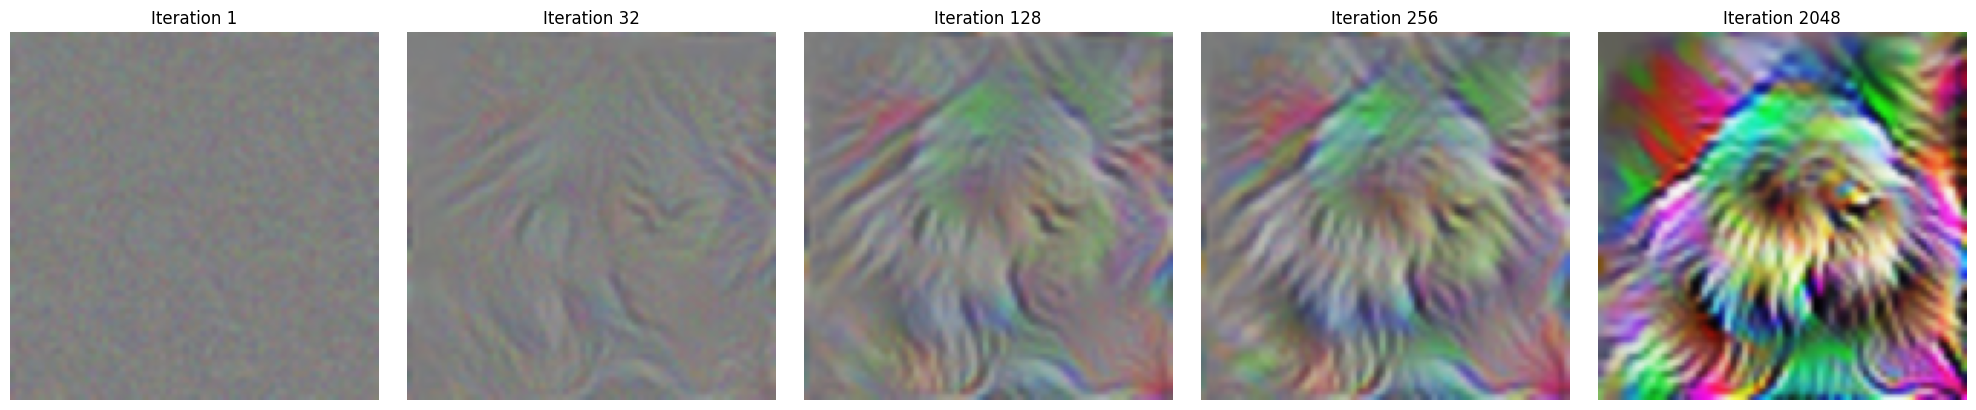

In [276]:
show_result(imgs_ds, thresholds)

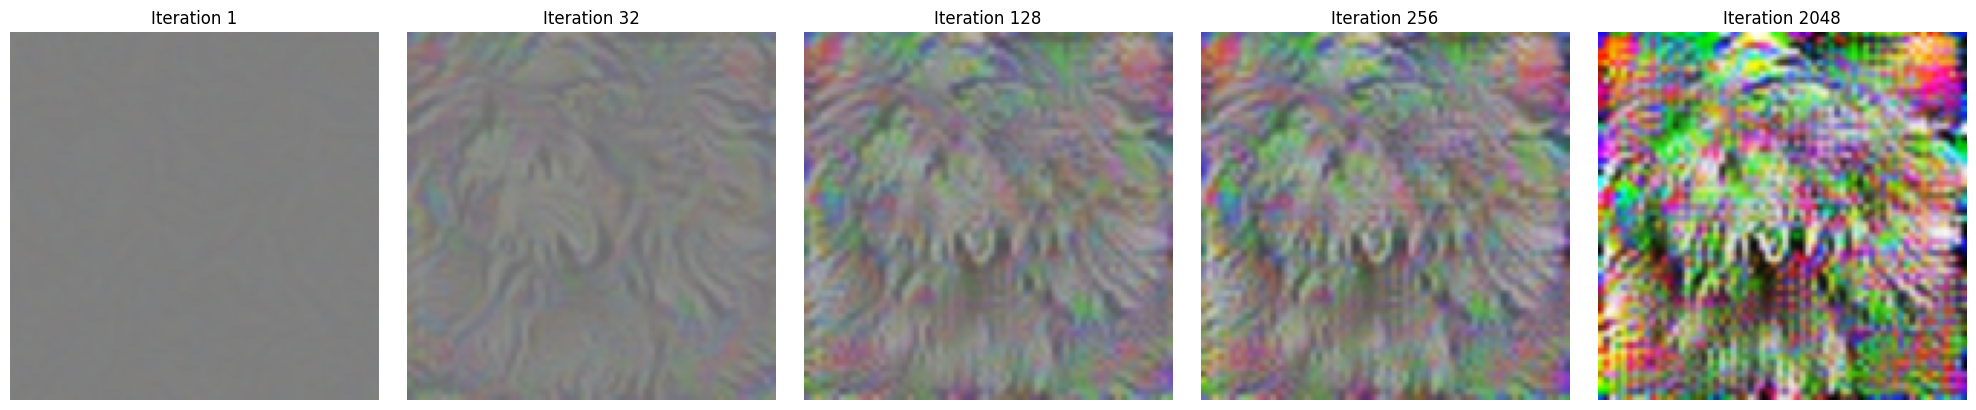

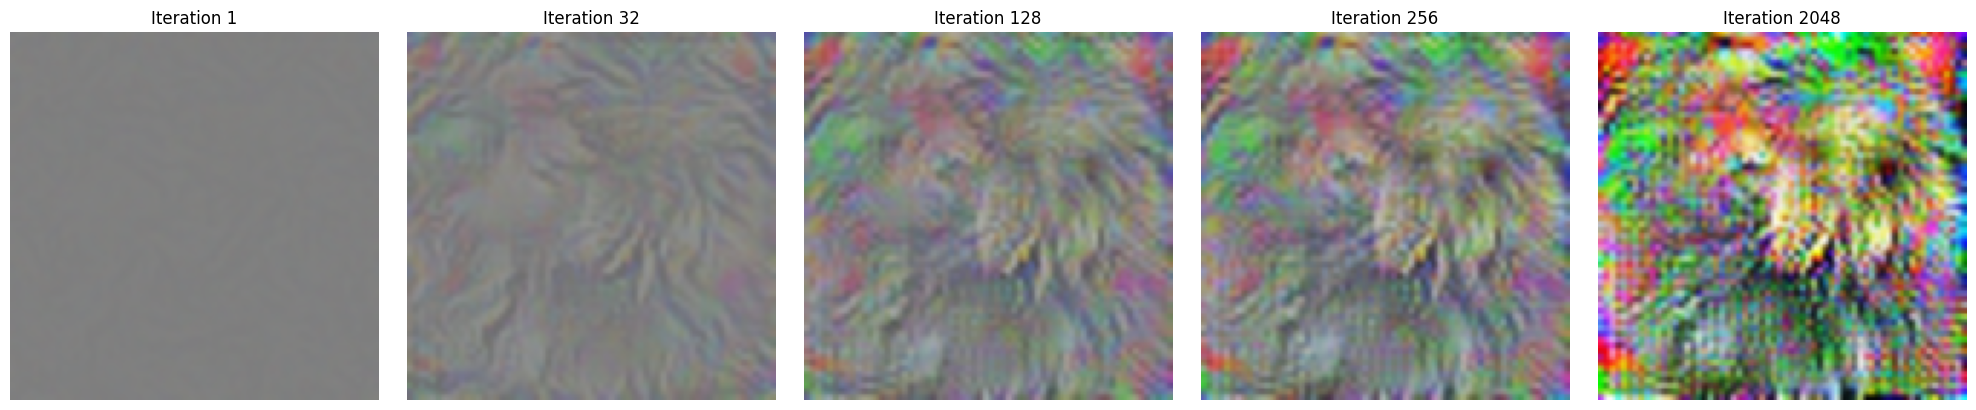

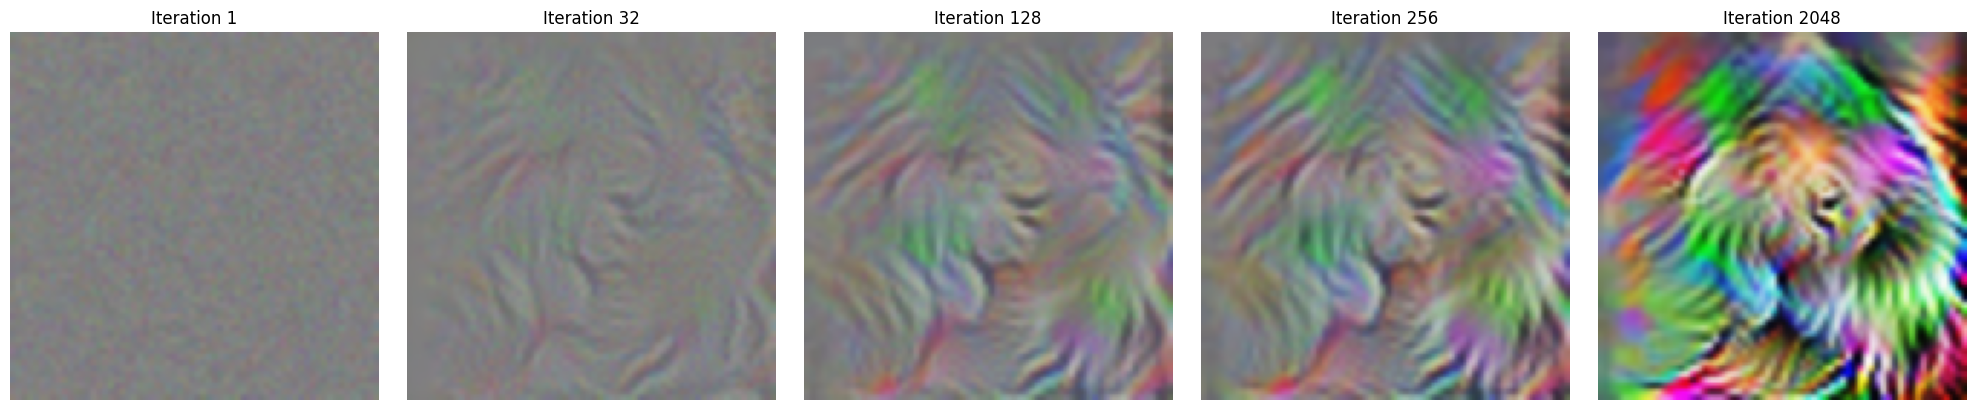

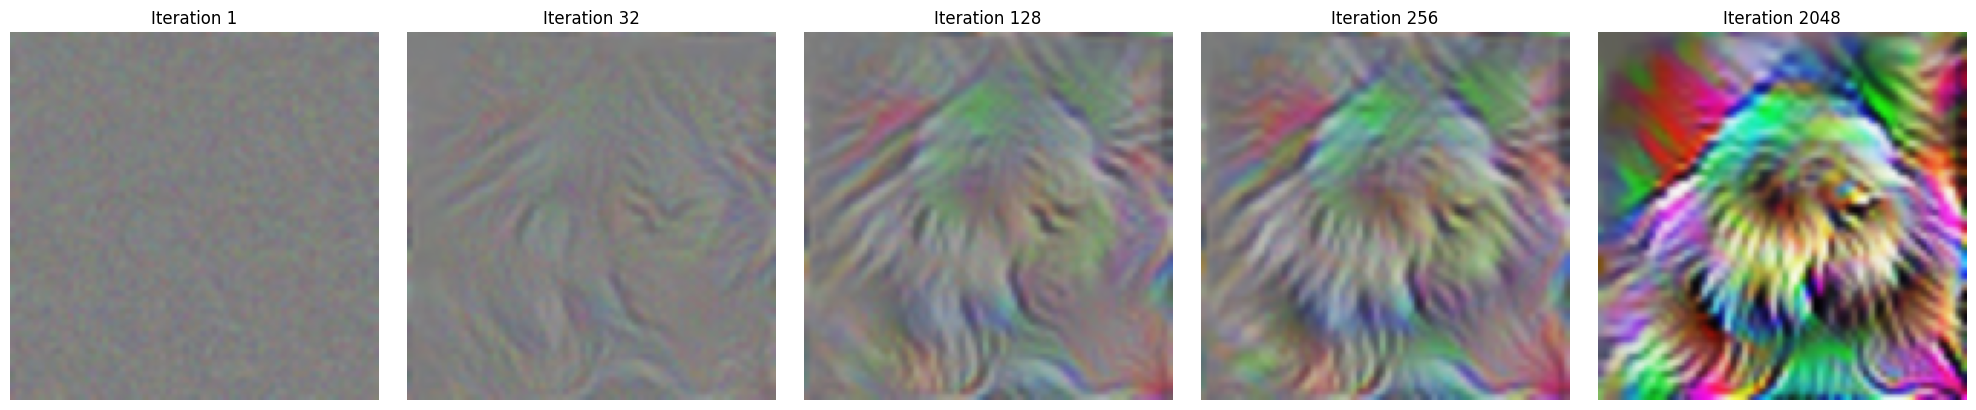

In [277]:
# FINAL RESULTS
show_result(imgs, thresholds)
show_result(imgs_tv, thresholds)
show_result(imgs_tr, thresholds)
show_result(imgs_ds, thresholds)